In [1]:
###Python Packages###

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import LogNorm
import math as mth
import timeit
from scipy import optimize
from scipy import *
import scipy
from scipy import stats
import tables
import h5py
import ODE_utils as odeu
from scipy.integrate import cumtrapz as trapint
import os
import shutil
#import matplotlib.animation as animation
#!jt -t onedork -cellw 90%

/home/brandon/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### This code displays results for every function

This is a comprehensive code that is less focused but possibly the most useful code to get an over all picture of the results


In [2]:
uscal=1
vscal=1
extraterms=True

path="results/vacuum-N=400"
try:
    os.mkdir(path)
except:
    print("File already exists")

uscal and vscal reduce arrays by their value in order to prevent memory overflow. Use when h5 files are very large (i.e. >2gB)

In [3]:
extension='0'
datapath='data/'+extension+'/'
rnputil=np.load(datapath+'rnputil.npy')
urange=np.load(datapath+'urange.npy')[::uscal]
vrange=np.load(datapath+'vrange.npy')[::vscal]

In [4]:
with h5py.File(datapath+'rnp.h5','r') as f:
    r_group_key = list(f.keys())[0]
    rnpi=f[r_group_key]
    rnp = np.asarray(rnpi[::uscal,::vscal],dtype=np.float_)    
with h5py.File(datapath+'signp.h5','r') as f:
    sig_group_key = list(f.keys())[0]
    signpi=f[sig_group_key]
    signp = np.asarray(signpi[::uscal,::vscal],dtype=np.float_)
with h5py.File(datapath+'phinp.h5','r') as f:
    phi_group_key = list(f.keys())[0]
    phinpi=f[phi_group_key]
    phinp = np.asarray(phinpi[::uscal,::vscal],dtype=np.float_)
with h5py.File(datapath+'massnp.h5','r') as f:
    mass_group_key = list(f.keys())[0]
    massnpi=f[mass_group_key]
    massnp = np.asarray(massnpi[::uscal,::vscal])
    
    
if extraterms==True:
    with h5py.File(datapath+'drnpu.h5','r') as f:
        dru_group_key = list(f.keys())[0]
        drnpui=f[dru_group_key]
        drnpu = np.asarray(drnpui[::uscal,::vscal],dtype=np.float_)
    with h5py.File(datapath+'drnpv.h5','r') as f:
        drv_group_key = list(f.keys())[0]
        drnpvi=f[drv_group_key]
        drnpv = np.asarray(drnpvi[::uscal,::vscal],dtype=np.float_)
        
    with h5py.File(datapath+'dsignpu.h5','r') as f:
        dsigu_group_key = list(f.keys())[0]
        dsignpui=f[dsigu_group_key]
        dsignpu = np.asarray(dsignpui[::uscal,::vscal],dtype=np.float_)
    with h5py.File(datapath+'dsignpv.h5','r') as f:
        dsigv_group_key = list(f.keys())[0]
        dsignpvi=f[dsigv_group_key]
        dsignpv = np.asarray(dsignpvi[::uscal,::vscal],dtype=np.float_)
        
    with h5py.File(datapath+'dphinpu.h5','r') as f:
        dphiu_group_key = list(f.keys())[0]
        dphinpui=f[dphiu_group_key]
        dphinpu = np.asarray(dphinpui[::uscal,::vscal],dtype=np.float_)
    with h5py.File(datapath+'dphinpv.h5','r') as f:
        dphiv_group_key = list(f.keys())[0]
        dphinpvi=f[dphiv_group_key]
        dphinpv = np.asarray(dphinpvi[::uscal,::vscal],dtype=np.float_)
    
    

print(str(rnp.nbytes)+" bytes")

print(rnp)

switchax=rnputil[9]
#extension=rnputil[11]
print(switchax)
if switchax==True:
    rnp=np.swapaxes(rnp,0,1)
    signp=np.swapaxes(signp,0,1)
    #phinp=np.swapaxes(phinp,0,1)
    #massnp=np.swapaxes(massnp,0,1)
    print("Switched Axes")

#print(massnp[1])
#print(rnp[:,4])

146304000 bytes
[[ 5.          5.00079053  5.00158113 ... 12.65100683 12.65206555
  12.65312429]
 [ 4.9201595   4.92094325  4.92172706 ... 12.54369725 12.54475439
  12.54581154]
 [ 4.840319    4.84109576  4.84187258 ... 12.43560401 12.43665953
  12.43771506]
 ...
 [ 0.07516367  0.14363312  0.17028082 ...  0.56410969  0.56410969
   0.56410969]
 [ 0.07508571  0.14362637  0.17027649 ...  0.56410969  0.56410969
   0.56410969]
 [ 0.07500774  0.14361968  0.1702722  ...  0.56410969  0.56410969
   0.56410969]]
False


In [5]:
print(rnputil)

N=int(rnputil[0])
Nu=len(urange)#int(rnputil[1])
Nv=len(vrange)#int(rnputil[2])
ru0=float(rnputil[3])
dr0v=float(rnputil[4])
M0=float(rnputil[5])
Q=float(rnputil[6])
Lambda=float(rnputil[7])
umax=np.nanmax(urange)
vmax=np.nanmax(vrange)

M=massnp[1][-1]
print(M,massnp[1,-1])

dv0=vrange[1]-vrange[0]

    
#M=nan.max(massnp)

def fr(r,M,Q,Lambda):
    return 1-2*M/r+Q**2.0/r**2.0-Lambda*r**2.0/3.0

if Lambda==0.0:
    sol = optimize.root(fr,[0.2,1.435],args=(M,Q,Lambda), method='hybr',tol=.0000001)
    rminus=sol.x[0]
    rplus=sol.x[1]
    rcosm=np.inf

if Lambda>0.0:
    sol = optimize.root(fr,[0.2,1.41,170],args=(M,Q,Lambda), method='hybr',tol=.0000001)
    rminus=sol.x[0]
    rplus=sol.x[1]
    rcosm=sol.x[2]
print('---')
print(M,Q,Lambda)
print('---')
print(0.0,rminus,rplus,rcosm)


['400' '2286' '8000' '5.0' '0.3162' '1.0' '0.9' '0.0' 'True' 'False' 'edd']
1.000000000040191 1.000000000040191
---
1.000000000040191 0.9 0.0
---
0.0 0.5641101055939193 1.4358898944864626 inf


In [6]:
def kappa(fr,r,M,Q,Lambda):
    return 0.5*np.abs(scipy.misc.derivative(fr,r,dx=.00000001,n=1,args=(M,Q,Lambda)))
#def kappa2(dfr,r,M,Q,Lambda):
    #return optimize.root(dfr,[0.01,1.5,50.0],args=(M,Q,Lambda),tol=10**(-10), method='hybr')

kappaplus=kappa(fr,rplus,M,Q,Lambda)
kappaminus=kappa(fr,rminus,M,Q,Lambda)
kappacosm=kappa(fr,rcosm,M,Q,Lambda)
print('k+: '+str(kappaplus),'k-: '+str(kappaminus),'kc: '+str(kappacosm))
###double-check for Lambda=0
###kappaminus
#print(np.abs((M*rminus-Q**2)/rminus**3.0))
#print(0.5*np.abs(dfr(rminus,M,Q,Lambda)))
###

#print(kappaplus-kappacosm)


k+: 0.21141437767102644 k-: 1.3697743939111717 kc: nan


In [7]:
uval=Nu-1#Nu-1#for single value graphs, this chooses the index in the u direction
print(0,Nu,urange[-1])
ulist=[1,2,3,4,5,6,7,8,9,9.955,10.25,10.5,11,11.5,12,13,14,15,15.5]
uind=[]
for i in ulist:
    uind.append((np.abs(urange-i)).argmin())

dercorr=1.0  #this is legacy, eddington coordinates are already correct      #dr0v/0.5/np.abs(1-2*massnp[0][0]/rnp[0][0]+Q**2/rnp[0][0]**2-Lambda*(rnp[0][0])**2.0/3.0)
vrange2=vrange*dercorr
#print(dercorr)

0 2286 15.57558990481418


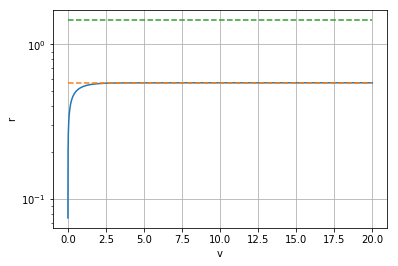

In [8]:
plt.plot(vrange,rnp[uval])
plt.plot([min(vrange),max(vrange)],[rminus,rminus],'--')
plt.plot([min(vrange),max(vrange)],[rplus,rplus],'--')
if Lambda>0.0:
    plt.plot([min(vrange),max(vrange)],[rcosm,rcosm],'--')
#plt.ylim(rcosm-.0000001,rcosm+.0000001)
#plt.ylim(rminus-.001,rminus+.001)
plt.xlabel('v')
plt.ylabel('r')
#plt.ylim(0.1,4.0)
#plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.show()

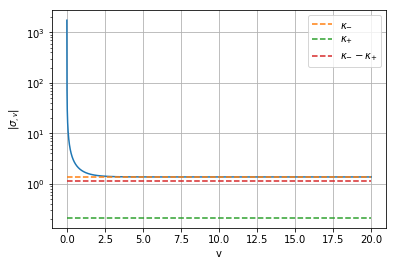

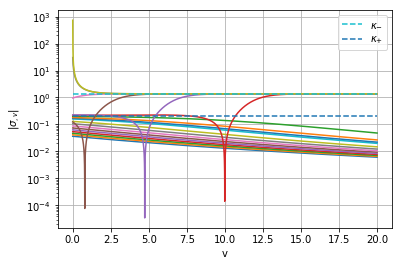

0.0 1.3697786300266284 1.3697743939111717
2286 8000
0.0 [-1.36977863 -7.46555312]
0.0 -1.3697786368574878


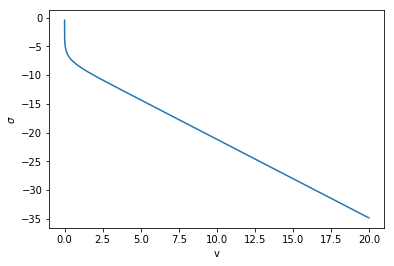

1.3697786197865838
0.0 nan 1.3697743939111717 0.21141437767102644
0.0 nan
0.0 1.1583600162401453


In [9]:
plt.plot(vrange2,np.abs(dsignpv[uval])/dercorr)
#plt.plot(vrange2,np.abs(dsignpu[uval])/dercorr)
plt.plot([min(vrange2),max(vrange2)],[kappaminus,kappaminus],'--',label=r'$\kappa_{-}$')
#plt.plot([min(vrange),max(vrange)],[kappaminus-kappacosm,kappaminus-kappacosm],'--',label=r'$\kappa_{-}-\kappa_{c}$')
#plt.plot([min(vrange),max(vrange)],[kappaminus-kappaplus,kappaminus-kappaplus],'--',label=r'$\kappa_{-}-\kappa_{+}$')
plt.plot([min(vrange2),max(vrange2)],[kappaplus,kappaplus],'--',label=r'$\kappa_{+}$')
if Lambda>0.0:
    plt.plot([min(vrange2),max(vrange2)],[kappacosm,kappacosm],'--',label=r'$\kappa_{c}$')
    plt.plot([min(vrange2),max(vrange2)],[kappaminus-2*kappacosm,kappaminus-2*kappacosm],'--',label=r'$\kappa_{-}-2\kappa_{c}$')
plt.plot([min(vrange2),max(vrange2)],[kappaminus-kappaplus,kappaminus-kappaplus],'--',label=r'$\kappa_{-}-\kappa_{+}$')
#plt.plot([min(vrange),max(vrange)],[kappaplus-kappacosm,kappaplus-kappacosm],'--',label=r'$\kappa_{c}$')
plt.yscale('log')
#plt.ylim(1,2)
#plt.ylim(.4,1)
plt.xlabel('v')
plt.ylabel(r'|$\sigma_{,v}$|')
plt.legend(loc='best')
plt.grid()
plt.show()

#numlines=10
for i in uind:
    #plt.plot((rnp[i]),vrange2)
    plt.plot(vrange2,np.abs(dsignpv[i])/dercorr)
plt.plot([min(vrange2),max(vrange2)],[kappaminus,kappaminus],'--',label=r'$\kappa_{-}$')
#plt.plot([min(vrange),max(vrange)],[kappaminus-kappacosm,kappaminus-kappacosm],'--',label=r'$\kappa_{-}-\kappa_{c}$')
#plt.plot([min(vrange),max(vrange)],[kappaminus-kappaplus,kappaminus-kappaplus],'--',label=r'$\kappa_{-}-\kappa_{+}$')
plt.plot([min(vrange2),max(vrange2)],[kappaplus,kappaplus],'--',label=r'$\kappa_{+}$')
if Lambda>0.0:
    plt.plot([min(vrange2),max(vrange2)],[kappacosm,kappacosm],'--',label=r'$\kappa_{c}$')
    plt.plot([min(vrange2),max(vrange2)],[kappaminus-2*kappacosm,kappaminus-2*kappacosm],'--',label=r'$\kappa_{-}-2\kappa_{c}$')
#plt.plot([min(vrange2),max(vrange2)],[kappaminus-kappaplus,kappaminus-kappaplus],'--',label=r'$\kappa_{-}-\kappa_{+}$')
#plt.plot([min(vrange),max(vrange)],[kappaplus-kappacosm,kappaplus-kappacosm],'--',label=r'$\kappa_{c}$')
plt.yscale('log')
#plt.ylim(1,2)
#plt.ylim(.4,1)
plt.xlabel('v')
plt.ylabel(r'|$\sigma_{,v}$|')
plt.legend(loc='best')
plt.grid()
plt.savefig(path+'/dsigdv_vs_v.png',dpi=300)
plt.show()
print(0.0,np.abs(dsignpv[uval][-5]),kappaminus)

print(Nu,Nv)
v1=Nv-20
v2=Nv-1
print(0.0,np.polyfit(vrange2[v1:v2],signp[uval][v1:v2],1.0))
print(0.0,dsignpv[uval][v2])

plt.plot(vrange2,signp[uval])
plt.plot(vrange2[v1:v2],signp[uval][v1:v2])
plt.xlabel('v')
plt.ylabel(r'$\sigma$')
plt.show()

print(np.abs(dsignpv[uval][int((v1+v2)/2)]))
print(0.0,kappacosm,kappaminus,kappaplus)
print(0.0,kappaminus-kappacosm)
print(0.0,kappaminus-kappaplus)

8000 1.0
0.0 [-11.05411777   9.99579214] [-1.39590521 -1.75788971]
0.0 [-11.05411777   9.99579214] [-1.69878584  2.40548745 -4.32266764]


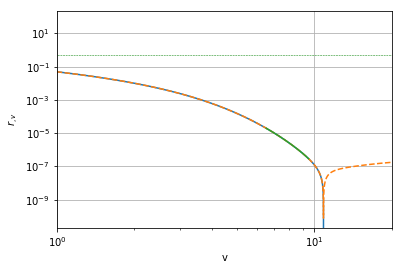

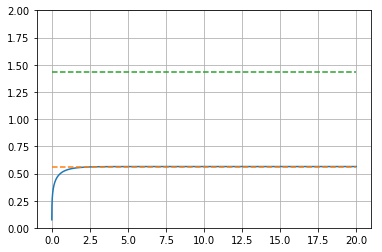

0.0 nan 0.21141437767102644 1.3697743939111717
1.1583600162401453
nan


In [10]:
v1=int(Nv-2700*4/2)
v2=int(Nv-2100*4/2)#1200
print(Nv,dercorr)

rpower=np.polyfit(np.log(vrange2[v1:v2]),np.log(np.abs(drnpv[uval][v1:v2]/dercorr)),1.0)
rpowere=(np.polyfit(vrange2[v1:v2],np.log(np.abs(drnpv[uval][v1:v2]/dercorr)),1.0))

print(0.0,rpower,rpowere)

rfit=odeu.drdvparam(vrange2[v1:v2],np.log(np.abs(drnpv[uval][v1:v2])))
rfite=odeu.massparam(vrange2[v1:v2],np.log(np.abs(drnpv[uval][v1:v2])))

print(0.0,rfit,rfite)

plt.plot(vrange2,drnpv[uval])
plt.plot(vrange2,np.abs(drnpv[uval]/dercorr),'--')
#plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)),'-.')
plt.plot(vrange2[v1:v2],np.abs(drnpv[uval][v1:v2]/dercorr))
#plt.plot(vrange2[v1:v2-1],np.log(np.abs(np.diff(rnp[uval][v1:v2])/np.diff(vrange2[v1:v2]))),'-.')
#plt.xlim(30,100)
plt.plot([vrange2[0],vrange2[-1]],[.5,.5],'g--',linewidth=.5)
plt.yscale('log')
plt.xscale('log')
plt.xlim(1,vrange2[-1])
plt.xlabel('v')
plt.ylabel(r'$r_{,v}$')
plt.grid()
plt.savefig(path+'/drdv_slope_vs_v.png',dpi=300)
plt.show()



plt.plot(vrange,rnp[uval])
plt.plot([min(vrange),max(vrange)],[rminus,rminus],'--')
plt.plot([min(vrange),max(vrange)],[rplus,rplus],'--')
if Lambda>0.0:
    plt.plot([min(vrange),max(vrange)],[rcosm,rcosm],'--')

plt.grid()
plt.ylim(.001,2.0)
#plt.yscale('log')
plt.show()

#print(0.0,np.polyfit(np.log(vrange2[v1:v2-1]),np.log(np.abs(np.diff(rnp[uval][v1:v2])/np.diff(vrange2[v1:v2]))),1.0))
print(0.0,kappacosm,kappaplus,kappaminus)
print(kappaminus-kappaplus)
print(kappaminus-kappacosm)

No handles with labels found to put in legend.


0.0 2286


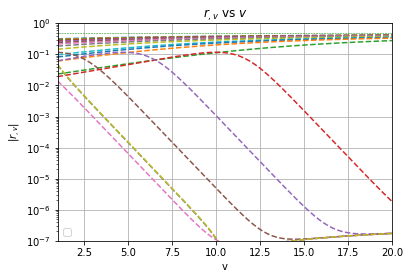

No handles with labels found to put in legend.


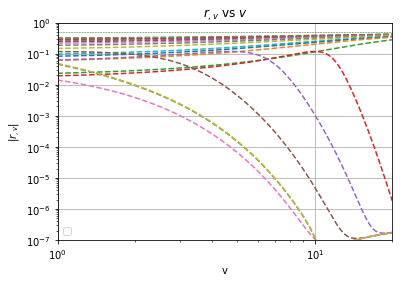

0.0 2286


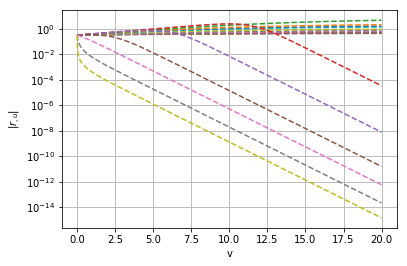

0.0 2286


/home/brandon/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


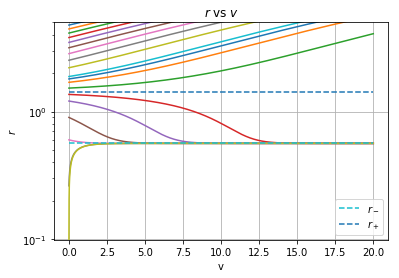

In [11]:
print(0.0,Nu)
#numlines=10
ims=[]
for i in uind:
    #print(0.0,i)
    #plt.plot(vrange2,(drnpv[i])/dercorr)
    plt.plot(vrange,np.abs(drnpv[i])/dercorr,'--')
    #print(urange[i])
    #ims=ims.append([plt.imshow(np.abs(drnpv[i]),animated=True)])
    #plt.plot(vrange2,drnpv[i]/dercorr)
#plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)),'-.')
#plt.plot([np.nan],[np.nan],'b',label=r'$r_{,v}$')
#plt.plot([np.nan],[np.nan],'b--',label=r'$|r_{,v}|$')
plt.plot([vrange2[0],vrange2[-1]],[.5,.5],'g--',linewidth=.5)
plt.xlabel('v')
plt.ylabel(r'$|r_{,v}|$')
plt.yscale('log')
#plt.xscale('log')
plt.ylim(10**(-7),10**0)
plt.legend(loc='best')
plt.grid()
plt.title(r'$r_{,v}$ vs $v$')
plt.xlim(1,vmax)
#plt.ylim(10**(-7),10**0)
plt.savefig(path+'/drdv_vs_v.png',dpi=300)
plt.show()

for i in uind:
    #print(0.0,i)
    #plt.plot(vrange2,(drnpv[i])/dercorr)
    plt.plot(vrange,np.abs(drnpv[i])/dercorr,'--')
    #print(urange[i])
    #ims=ims.append([plt.imshow(np.abs(drnpv[i]),animated=True)])
    #plt.plot(vrange2,drnpv[i]/dercorr)
#plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)),'-.')
#plt.plot([np.nan],[np.nan],'b',label=r'$r_{,v}$')
#plt.plot([np.nan],[np.nan],'b--',label=r'$|r_{,v}|$')
plt.plot([vrange2[0],vrange2[-1]],[.5,.5],'g--',linewidth=.5)
plt.xlabel('v')
plt.ylabel(r'$|r_{,v}|$')
plt.yscale('log')
plt.xscale('log')
plt.ylim(10**(-7),10**0)
plt.legend(loc='best')
plt.grid()
plt.title(r'$r_{,v}$ vs $v$')
plt.xlim(1,vmax)
#plt.ylim(10**(-7),10**0)
plt.savefig(path+'/drdv_vs_v_log.png',dpi=300)
plt.show()

print(0.0,Nu)
#numlines=5
for i in uind:
    #plt.plot(vrange2,drnpu[i]/dercorr)
    plt.plot(vrange2,np.abs(drnpu[i])/dercorr,'--')
    #plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)))
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('v')
plt.ylabel(r'|$r_{,u}|$')

plt.grid()
#plt.savefig('num-rel-pics/Tol=.05_N=100_Nv=100.png',dpi=300)
plt.savefig(path+'/drdu_vs_v.png',dpi=300)
plt.show()

print(0.0,Nu)
#numlines=5
ims=[]
for i in uind:
    #plt.plot((rnp[i]),vrange2)
    plt.plot(vrange2,np.abs(rnp[i])/dercorr)

#plt.axvline(rplus,linestyle='--',label=r'$r_+$')
#plt.axvline(rminus,'--',label=r'$r_-$')

plt.plot([min(vrange),max(vrange)],[rminus,rminus],'--',label=r'$r_-$')
plt.plot([min(vrange),max(vrange)],[rplus,rplus],'--',label=r'$r_+$')
plt.xlabel('v')
plt.ylabel(r'$r$')
plt.yscale('log')
#plt.xscale('log')
#plt.ylim(0,5.5)
plt.ylim(0,5)
plt.legend(loc='best')
plt.title(r'$r$ vs $v$')
plt.grid()
plt.savefig(path+'/r_vs_v.png',dpi=300)
plt.show()

0.0 2286


/home/brandon/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


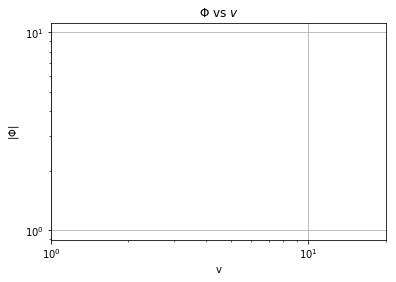

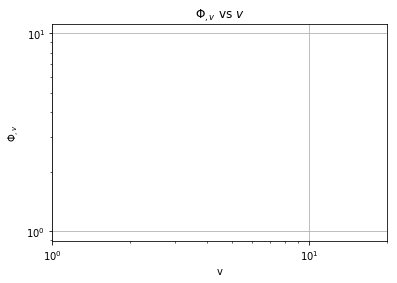

/home/brandon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


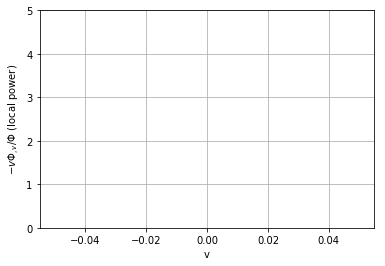

0.0 2286


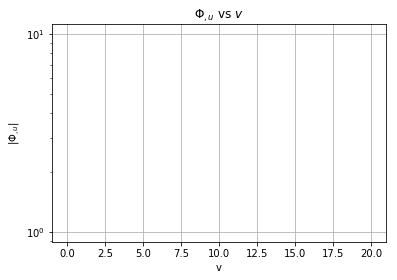

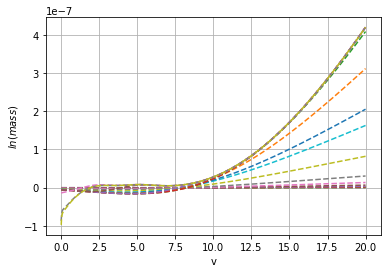

In [12]:
print(0.0,Nu)
#numlines=10
for i in uind:
    
    plt.plot(vrange2,np.abs(phinp[i])/dercorr,'--')
    #print(urange[i])
    #plt.plot(vrange2,drnpv[i]/dercorr)
#plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)),'-.')
#plt.xscale('log')
#plt.plot([np.nan],[np.nan],'b',label=r'$\Phi$')
#plt.plot([np.nan],[np.nan],'b--',label=r'$|\Phi|$')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$|\Phi|$')
plt.xlabel('v')
plt.xlim(1,vmax)
#plt.xlim(.5,vrange2[-1])
plt.grid()
plt.title(r'$\Phi$ vs $v$')
#plt.legend()
plt.savefig(path+'/Phis vs v.png',dpi=300)
plt.show()


#numlines=5
for i in uind:
    #plt.plot(vrange2,dphinpv[i]/dercorr)
    plt.plot(vrange2,np.abs(dphinpv[i])/dercorr,'--')
    #plt.plot(vrange2,drnpv[i]/dercorr)
#plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)),'-.')
#plt.plot([np.nan],[np.nan],'b',label=r'$\Phi_{,v}$')
#plt.plot([np.nan],[np.nan],'b--',label=r'$|\Phi_{,v}|$')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\Phi_{,v}$')
plt.xlabel('v')
plt.xlim(1,vmax)
plt.title(r'$\Phi_{,v}$ vs $v$')
plt.grid()
#plt.legend()
plt.savefig(path+'/dphidv vs v.png',dpi=300)
plt.show()

for i in uind:
    plt.plot(vrange2,-vrange2*dphinpv[i]/phinp[i]/dercorr)
    plt.ylim(0.0,5.0)
#plt.xscale('log')
plt.grid()
plt.ylabel(r'$-v \Phi_{,v} /\Phi$'+' (local power)')
plt.xlabel('v')
plt.savefig(path+'/Powers of Phi vs v.png',dpi=300)
plt.show()

print(0.0,Nu)
#numlines=5
for i in uind:
    #plt.plot(vrange2,drnpu[i]/dercorr)
    plt.plot(vrange2,np.abs(dphinpu[i])/dercorr,'--')
    #plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)))
plt.yscale('log')
plt.ylabel(r'$|\Phi_{,u}|$')
plt.xlabel('v')
#plt.xlim(0,6)
plt.title(r'$\Phi_{,u}$ vs $v$')
plt.grid()
plt.savefig(path+'/dphidu vs v.png',dpi=300)
plt.show()

for i in uind:
    #plt.plot(vrange2,drnpu[i]/dercorr)
    plt.plot(vrange2,np.log(massnp[i])/dercorr,'--')
    #plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)))
#plt.yscale('log')
plt.ylabel(r'$ln(mass)$')
plt.xlabel('v')
#plt.xlim(0,6)
#plt.title(r'$\Phi_{,u}$ vs $v$')
plt.grid()
plt.savefig(path+'/masses vs v.png',dpi=300)
#plt.savefig('num-rel-pics/drdu_Mf='+str(M)+'_Q='+str(Q)+'_Lambda='+str(Lambda)+'_edd.png',dpi=300)
plt.show()

17.5 19.5
0.0 [nan nan]
nan


/home/brandon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/home/brandon/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


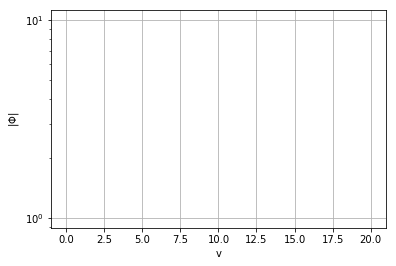

/home/brandon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/home/brandon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


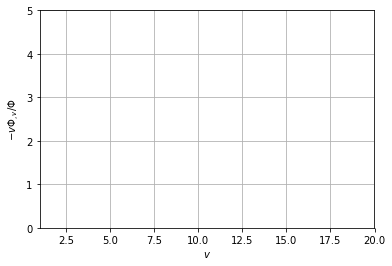

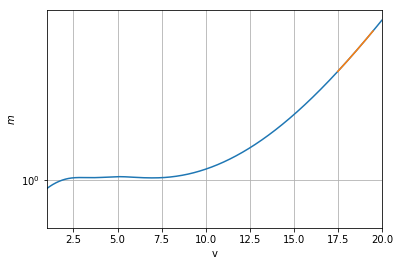

0.0 [ 5.32273691e-08 -6.47291722e-07]
0.0 [ 1.06641775e-07 -9.87521861e-07  1.24542281e-06]
0.0 1.3697743939111717


In [13]:
v1=int(Nv-500*4/2)
v2=int(Nv-100*4/2)
print(vrange2[v1],vrange2[v2])
print(0.0,np.polyfit(np.log(vrange2[v1:v2]),np.log(np.abs(phinp[uval][v1:v2])),1.0))
print(kappacosm)
plt.plot(vrange2,np.abs(phinp[uval])/dercorr)
plt.plot(vrange2[v1:v2],np.abs(phinp[uval][v1:v2])/dercorr)
#plt.xlim(1,vrange2[-1])
plt.yscale('log')
plt.ylabel(r'$|\Phi|$')
plt.xlabel('v')
#plt.xscale('log')
#plt.legend(loc='best')
plt.grid()
#plt.title('Phi along Event Horizon')
#plt.savefig('num-rel-pics/Phi vs v_bug_fixed.png',dpi=300)
plt.show()

plt.plot(vrange2,-vrange2*dphinpv[uval]/phinp[uval]/dercorr)
plt.plot(vrange2[v1:v2],-vrange2[v1:v2]*dphinpv[uval][v1:v2]/phinp[uval][v1:v2]/dercorr)
plt.ylim(0.0,5.0)
#plt.xscale('log')
plt.ylabel(r'$-v \Phi_{,v} /\Phi$')
plt.xlabel(r'$v$')
plt.xlim(1,vrange2[-1])
plt.grid()
#plt.savefig('num-rel-pics/Power of Phi vs v_bug_fixed.png',dpi=300)
plt.show()

#numlines=10


masse=np.polyfit(vrange2[v1:v2],np.log(np.abs(massnp[uval][v1:v2])),1.0)
plt.plot(vrange2,np.abs(massnp[uval])/dercorr)
plt.plot(vrange2[v1:v2],np.abs(massnp[uval][v1:v2])/dercorr)
plt.xlim(1,vrange[-1])
plt.yscale('log')
plt.xlabel('v')
#plt.xscale('log')
#plt.legend(loc='best')
plt.xlabel('v')
plt.ylabel(r'$m$')
plt.grid()
#plt.savefig(path+'/Phi vs v.png',dpi=300)
plt.savefig(path+'/mass_vs_v.png',dpi=300)
plt.show()

massfit=odeu.massparam(vrange2[v1:v2],np.log(massnp[uval][v1:v2]))
print(0.0,masse)
print(0.0,massfit)
print(0.0,kappaminus)

0.0 [nan nan]


/home/brandon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/brandon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/home/brandon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


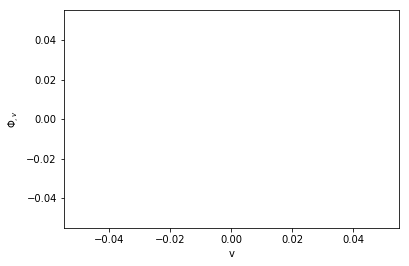

0.0 nan


In [14]:
v1=int(Nv-2700*4/2)
v2=int(Nv-2100*4/2)
dphidvpower=np.polyfit(np.log(vrange2[v1:v2]),np.log(np.abs(dphinpv[uval][v1:v2]/dercorr)),1.0)
print(0.0,dphidvpower)
plt.plot(vrange2,np.log(np.abs(dphinpv[uval])))
plt.plot(vrange2[v1:v2],np.log(np.abs(dphinpv[uval][v1:v2])))
plt.xlabel('v')
plt.ylabel(r'$\Phi_{,v}$')
plt.savefig(path+'/Phi_vs_v.png',dpi=300)
plt.show()
print(0.0,kappacosm)


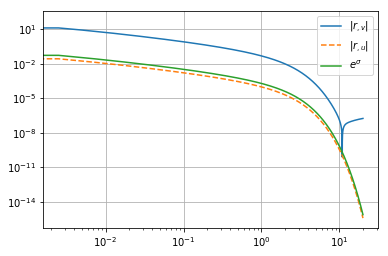

In [15]:
#plt.plot(vrange2,np.abs(massnp[uval]))
plt.plot(vrange2,np.abs(drnpv[uval]),label=r'$|r_{,v}|$')
plt.plot(vrange2,np.abs(drnpu[uval]),'--',label=r'$|r_{,u}|$')
plt.plot(vrange2,np.abs(np.exp(signp[uval])),label=r'$e^{\sigma}$')
#plt.ylim(massnp[uval,-1]-.00000000001,massnp[uval,-1]+.00000000001)
plt.xscale('log')
plt.yscale('log')
#plt.xlim(100,300)
plt.legend(loc='best')
plt.grid()
#plt.savefig('num-rel-pics/esig-drdv-drdu.png',dpi=300)
plt.show()


8000
[ 1.43438455 -9.39305816]


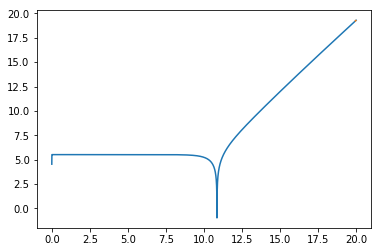

0.0 1.3697743939111717 nan 0.9469456385691188


In [16]:
print(Nv)
uval2=Nu-1
v1=Nv-20
v2=Nv-10
print(np.polyfit(vrange2[v1:v2],np.log(np.abs(np.exp(-signp[uval2][v1:v2])*drnpv[uval2][v1:v2])),1.0))
plt.plot(vrange2,np.log(np.abs(np.exp(-signp[uval2])*drnpv[uval2])))
plt.plot(vrange2[v1:v2],np.log(np.abs(np.exp(-signp[uval2][v1:v2])*drnpv[uval2][v1:v2])))
plt.show()

print(0.0,kappaminus,kappaminus-2*kappacosm,kappaminus-2*kappaplus)

In [17]:
shutil.copy(datapath+'Initial-Conditions.txt',path+'/Initial-Conditions.txt')
os.rename(path+'/Initial-Conditions.txt',path+'/Initial-Conditions-Results.txt')

f=open(path+'/Initial-Conditions-Results.txt','a')
f.write('\n')
f.write('###Results###\n')
f.write('\n')
f.write('Mf='+str(massnp[0][-1])+'\n')
f.write('rplus='+str(rplus)+'\n')
f.write('rminus='+str(rminus)+'\n')
f.write('\n')
f.write('kappaplus='+str(kappaplus)+'\n')
f.write('kappaminus='+str(kappaminus)+'\n')
if Lambda>0.0:
    f.write('kappacosm='+str(kappacosm)+'\n')
f.write('\n')
f.write('drdv power='+str(rpower)+'\n')
f.write('drdv exp term='+str(rpowere)+'\n')
f.write('drdv power fitting='+str(rfit)+'\n')
f.write('drdv power exp fitting='+str(rfite)+'\n')
f.write('\n')
f.write('mass exp term='+str(masse)+'\n')
f.write('mass fit='+str(massfit)+'\n')
f.write('\n')
f.write('dphidv power='+str(dphidvpower)+'\n')

f.close()

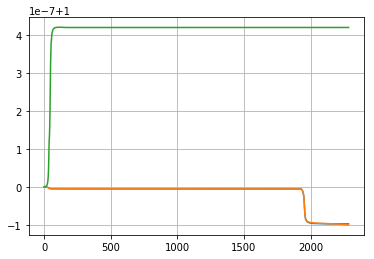

[[1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 ...
 [0.9999999  0.9999999  0.9999999  ... 1.00000042 1.00000042 1.00000042]
 [0.9999999  0.9999999  0.9999999  ... 1.00000042 1.00000042 1.00000042]
 [0.9999999  0.9999999  0.9999999  ... 1.00000042 1.00000042 1.00000042]]


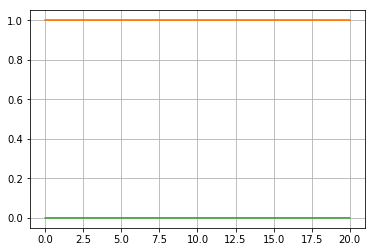

In [18]:
#plt.plot(urange,massnp[:,0])
#plt.plot(urange,massnp[:,1])
#plt.plot(urange,massnp[:,-1])
plt.plot(massnp[:,0])
plt.plot(massnp[:,1])
plt.plot(massnp[:,-1])
#plt.yscale('log')
plt.grid()
plt.show()
print(massnp)

plt.plot(vrange2,massnp[0])
plt.plot(vrange2,massnp[1])
plt.plot(vrange2,np.log(massnp[-10]))
#plt.yscale('log')
plt.grid()
plt.show()

In [19]:
print(len(rnp),len(drnpv),len(drnpu),len(dphinpv),len(dphinpu),len(massnp))
rnpf=np.delete(rnp,-1,axis=0)
massnpf=np.delete(massnp,-1,axis=0)
print(len(rnpf),len(drnpv),len(drnpu),len(dphinpv),len(dphinpu),len(massnpf))
Curvature=odeu.Kretsch(rnp,drnpv,drnpu,dphinpv,dphinpu,massnp,Q,Lambda)


2286 2286 2286 2286 2286 2286
2285 2286 2286 2286 2286 2285


0.0 2057


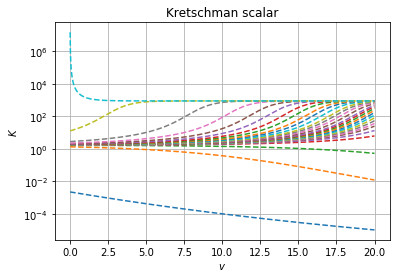

In [20]:
#plt.plot(vrange2,Curvature[30])
#plt.show()
Nuf=int(Nu*9/10)

print(0.0,Nuf)
numlines=30
for i in range(numlines):
    i=int(i*Nuf/numlines)
   
    plt.plot(vrange2,Curvature[i],'--')
plt.xlabel(r'$v$')
plt.ylabel(r'$K$')
plt.yscale('log')
plt.grid()
plt.title('Kretschman scalar')
plt.savefig(path+'/K vs v.png',dpi=300)
#plt.savefig('num-rel-pics/K vs v.png',dpi=300)
plt.show()

print(rminus)
odeu.Kretsch(rminus,1,1,0,0,M0,Q,Lambda)

### This last section is meant for Eddington Coordinates (u and v) only

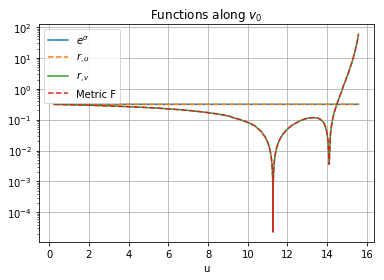

In [21]:
metricf=0.5*np.abs(1-2*massnp/rnp+Q**2.0/rnp**2.0-Lambda*rnp**2.0/3)

plt.plot(urange,0.5*np.exp(signp[:,0]),label=r'$e^{\sigma}$')
plt.plot(urange,np.abs(drnpu[:,0]),'--',label=r'$r_{,u}$')
plt.plot(urange,np.abs(drnpv[:,0]),label=r'$r_{,v}$')
plt.plot(urange,metricf[:,0],'--',label=r'Metric F')
#plt.plot(urange,np.abs(dsignpu[:,0]),label=r'$r_{,v}$')
#plt.xlim(99,100)
plt.yscale('log')
plt.xlabel('u')
plt.grid()
plt.legend(loc='best')
plt.title(r'Functions along $v_{0}$')
#plt.savefig('num-rel-pics/esig_drdu_drdv_vs_u_v0.png',dpi=300)
plt.show()


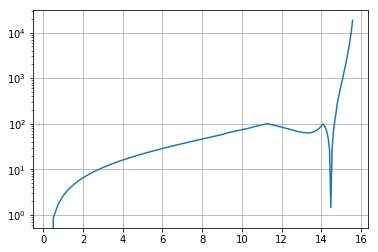

186.07524569552487


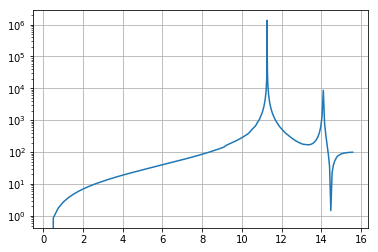

0.9946545573344987


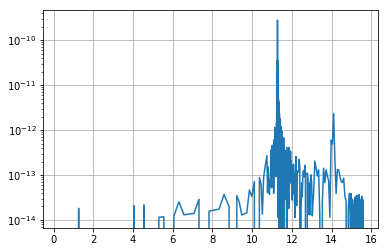

/home/brandon/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


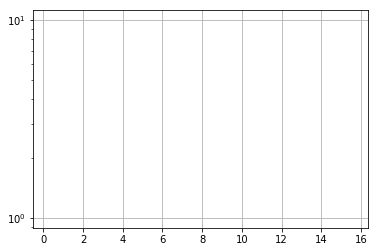

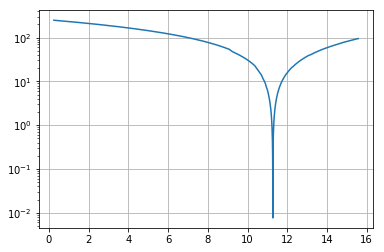

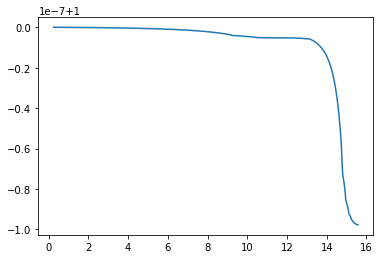

1.0 0.9999999999833061 0.9999999999654918
0.07500773577362137
1.4358898944864626


In [22]:
plt.plot(urange,np.abs(0.5*np.exp(signp[:,0])-np.abs(drnpv[:,0]))/(0.5*np.exp(signp[:,0]))*100)
plt.yscale('log')
plt.grid()
plt.show()

print((np.abs(0.5*np.exp(signp[:,0])-np.abs(drnpv[:,0]))/(0.5*np.exp(signp[:,0])))[-1])

plt.plot(urange,np.abs(metricf[:,0]-0.5*np.exp(signp[:,0]))/(metricf[:,0])*100)
plt.yscale('log')
plt.grid()
plt.show()

print((np.abs(metricf[:,0]-0.5*np.exp(signp[:,0]))/(metricf[:,0]))[-1])

plt.plot(urange,np.abs(metricf[:,0]-np.abs(drnpv[:,0]))/(metricf[:,0])*100)
plt.yscale('log')
plt.grid()
plt.show()


plt.plot(urange,np.abs(0.5*np.exp(signp[:,0])-np.abs(drnpu[:,0]))/(0.5*np.exp(signp[:,0]))*100)
plt.yscale('log')
plt.grid()
plt.show()

plt.plot(urange,np.abs(rnp[:,0]-rplus)/(rplus)*100)
plt.yscale('log')
plt.grid()
plt.show()

plt.plot(urange,massnp[:,0])
plt.show()
print(massnp[0,0],massnp[1,0],massnp[2,0])

#print(rnp[:,0])
print(rnp[-1,0])
print(rplus)

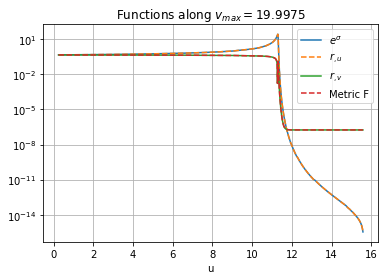

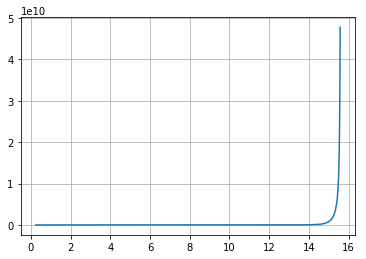

In [23]:
plt.plot(urange,0.5*np.exp(signp[:,-1]),label=r'$e^{\sigma}$')
plt.plot(urange,np.abs(drnpu[:,-1]),'--',label=r'$r_{,u}$')
plt.plot(urange,np.abs(drnpv[:,-1]),label=r'$r_{,v}$')
plt.plot(urange,0.5*np.abs(1-2*massnp[:,-1]/rnp[:,-1]+Q**2.0/rnp[:,-1]**2.0-Lambda*rnp[:,-1]**2.0/3),'--',label=r'Metric F')
#plt.plot(urange,np.abs(dsignpu[:,-1]),label=r'$r_{,v}$')
plt.yscale('log')
plt.yscale('log')
plt.xlabel('u')
plt.grid()
plt.legend(loc='best')
plt.title(r'Functions along $v_{max}=$'+str(vrange[-1]))
#plt.xlim(37.9396621,37.9396623)
#plt.savefig('num-rel-pics/esig_drdu_drdv_vs_u_vmax.png',dpi=300)
plt.show()

plt.plot(urange,np.abs(np.abs(drnpu[:,-1])-np.abs(drnpv[:,-1]))/(np.abs(drnpu[:,-1]))*100)
#plt.yscale('log')
plt.grid()
plt.show()

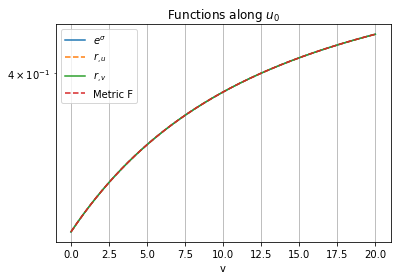

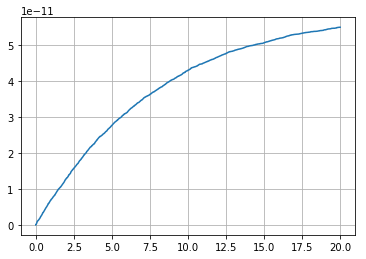

In [24]:
plt.plot(vrange,0.5*np.exp(signp[0]),label=r'$e^{\sigma}$')
plt.plot(vrange,np.abs(drnpu[0]),'--',label=r'$r_{,u}$')
plt.plot(vrange,np.abs(drnpv[0]),label=r'$r_{,v}$')
plt.plot(vrange,0.5*np.abs(1-2*massnp[0]/rnp[0]+Q**2.0/rnp[0]**2.0-Lambda*rnp[0]**2.0/3),'--',label=r'Metric F')
#plt.xlim(0,10)
plt.yscale('log')
plt.xlabel('v')
plt.grid()
plt.legend(loc='best')
plt.title(r'Functions along $u_{0}$')
#plt.savefig('num-rel-pics/esig_drdu_drdv_vs_u_u0.png',dpi=300)
plt.show()

plt.plot(vrange,np.abs(np.abs(drnpu[0])-np.abs(drnpv[0]))/(np.abs(drnpu[0]))*100)
#plt.yscale('log')
plt.grid()
plt.show()


0.0 2286 8000


/home/brandon/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


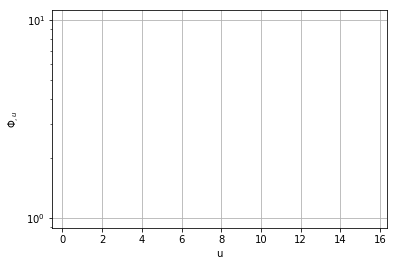

In [25]:
print(0.0,Nu,Nv)
numlines=20
for i in range(numlines):
    i=int(i*Nv/numlines)
    #plt.plot(vrange2,drnpu[i]/dercorr)
    plt.plot(urange,dphinpu[:,i],'--')
    #plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)))
plt.yscale('log')
plt.xlabel('u')
plt.ylabel(r'$\Phi_{,u}$')
#plt.xlim(0,6)
plt.grid()
#plt.savefig('num-rel-pics/Tol=.05_N=100_Nv=100.png',dpi=300)
#plt.savefig('num-rel-pics/dphidu_vs_u.png',dpi=300)
plt.show()

8000
0.0 [nan nan]


/home/brandon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/home/brandon/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


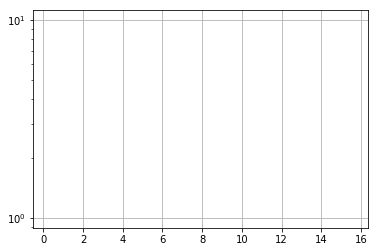

nan 0.21141437767102644 1.3697743939111717



In [26]:
print(Nv)
vval=Nv-1
u1=Nu-10
u2=Nu-5
print(0.0,np.polyfit(urange[u1:u2],np.log(np.abs(dphinpu[u1:u2,vval])),1.0))
plt.plot(urange,np.abs(dphinpu[:,vval]))
plt.plot(urange[u1:u2],np.abs(dphinpu[u1:u2,vval]))
plt.yscale('log')
#plt.xscale('log')
plt.grid()
plt.show()
print(kappacosm,kappaplus,kappaminus)
print()



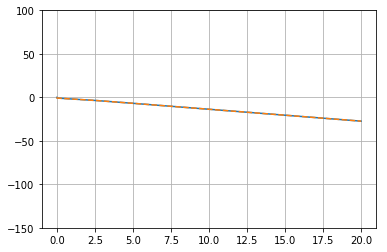

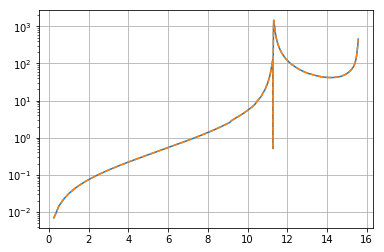

In [27]:
drnpvv=dsignpv[uval]*drnpv[uval]-rnp[uval]*(dphinpv[uval])**2.0
plt.plot(vrange2,vrange2*drnpvv/drnpv[uval])
plt.plot(vrange2,vrange2*dsignpv[uval],'--')
#-vrange2*dphinpv[i]/phinp[i]
#plt.plot(vrange2,-vrange2*drnpv[i]/rnp[i])
plt.grid()
#plt.yscale('log')
plt.ylim(-150,100)
plt.show()

drnpuu=dsignpu[:,vval]*drnpu[:,vval]-rnp[:,vval]*(dphinpu[:,vval])**2.0
plt.plot(urange,np.abs(urange*drnpuu/drnpu[:,vval]))
plt.plot(urange,np.abs(urange*dsignpu[:,vval]),'--')
#-vrange2*dphinpv[i]/phinp[i]
#plt.plot(vrange2,-vrange2*drnpv[i]/rnp[i])
plt.grid()
plt.yscale('log')
#plt.ylim(10**2,10**7)
plt.show()

No handles with labels found to put in legend.


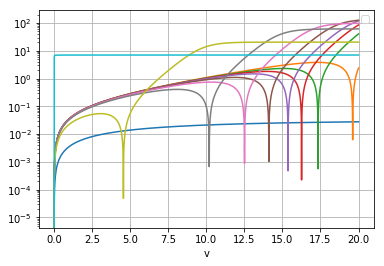

In [28]:
numlines=10
ims=[]
for i in range(numlines):
    i=int(i*Nu/numlines)
    plt.plot(vrange2,np.abs(dsignpu[i])/dercorr)
    #plt.plot(vrange2,np.abs(rnp[i])/dercorr,'--')
    
#plt.plot([min(vrange),max(vrange)],[rminus,rminus],'--',label=r'$r_-$')
#plt.plot([min(vrange),max(vrange)],[rplus,rplus],'--',label=r'$r_+$')
plt.xlabel('v')
#plt.ylabel(r'$r$')
plt.yscale('log')
#plt.xscale('log')
#plt.xlim(0,10)
plt.legend(loc='best')
#plt.title(r'$r$ vs $v$')
plt.grid()
#plt.savefig('num-rel-pics/r_vs_v.png',dpi=300)
plt.show()

In [29]:
1/(rnp[uval])*dv0*-.5*odeu.trapint(drnpu[uval]*dphinpv[uval])

array([-0., -0., -0., ..., -0., -0., -0.])

50000
dr/dv is -0.3162
Using Full Eddington Coordinates
[-3.16200000e-01 -3.16173500e-01 -3.16146994e-01 ... -8.83483941e-12
 -8.83017117e-12 -8.82550536e-12]
[3.16200000e-01 3.16173500e-01 3.16146994e-01 ... 8.83482674e-12
 8.83015845e-12 8.82549263e-12]


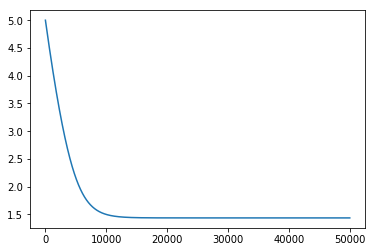

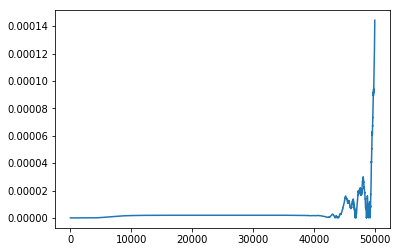

In [30]:
N=10
umax2=5000
Nu2=int(umax2*N)
print(Nu2)
boundary=odeu.boundaryv(1,'edd','edd',Nu2,ru0,-dr0v,dv0,vmax,M0,Q,Lambda,False,0,10,float,0.0)
print(boundary[3])
print(boundary[6])

plt.plot(boundary[0])
plt.show()

plt.plot(np.abs(np.abs(boundary[3])-np.abs(boundary[6]))/boundary[6]*100)
plt.show()

In [31]:
#drnpvf[] = -1/(4*drnpu[-1][0])*np.exp(signp[1][0])*(1-2*M0/rnp[1][0]+Q**2/rnp[1][0]**2-Lambda*rnp[1][0]**2/3)


2286
1.4282212816157847 0.8687799589018834


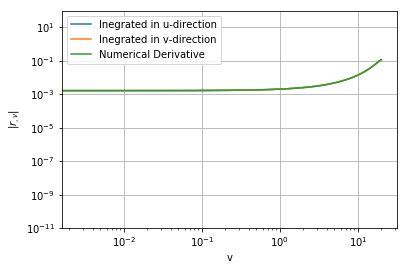

-0.0018061496855409987 -0.0018061493692644126


In [32]:
print(Nu)

uval3=348#-9000

print(rnp[uval3][0],rnp[uval3][-1])

dv=vrange[1]-vrange[0]

drnpvf = np.exp(signp[uval3])*(drnpv[uval3][0]*np.exp(-signp[uval3][0])-dv*trapint(rnp[uval3]*(dphinpv[uval3])**2.0*np.exp(-signp[uval3]),initial=0.0))
drnpvf2 =np.diff(rnp[uval3])/diff(vrange)

plt.plot(vrange,np.abs(drnpv[uval3]),label='Inegrated in u-direction')
plt.plot(vrange,np.abs(drnpvf),label='Inegrated in v-direction')
plt.plot(vrange[:-1],np.abs(drnpvf2),label='Numerical Derivative')
plt.ylim(10**(-11),10**2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('v')
plt.ylabel(r'$|r_{,v}|$')
plt.grid()
plt.legend(loc='best')
#plt.savefig('num-rel-pics/drdu_comparison.png',dpi=300)
plt.show()

print(drnpvf[200],drnpv[uval3][200])